In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import font_manager

font_dirs = ["./"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
sns.set( font = "Helvetica" )

In [3]:
### gather result
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import numpy as np

api = wandb.Api()

def normalize_name(x):
    if x in cpa_runs:
        return 'CPA'
    elif x in pertnet_runs:
        return 'GEARS'
    elif x in linear_runs:
        return 'GRN'
    else:
        return 'No-Perturb'

df_all_datasets = {}
df_all_datasets['replogle2022_rpe1'] = pd.read_csv('../../perturb_GNN/pertnet/replogle_rpe1_gw_filtered_hvg_frac.csv')
df_all_datasets['replogle2022_k562'] = pd.read_csv('../../perturb_GNN/pertnet/replogle_k562_essential_filtered_hvg_frac.csv')

In [4]:
# Project is specified by <entity/project-name> please replace it with your project name here:
runs = api.runs("kexinhuang/pert_gnn_simulation_norman2019")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })


run = 6
cpa_runs = ['CPA_' + str(i) for i in range(1, run)]
pertnet_runs = ['gears2_seed' + str(i) for i in range(1, run)]
no_perturb_runs = ['No_Perturb_' + str(i) for i in range(1, run)]
linear_runs = ['Linear_' + str(i) for i in range(1, run)]

res_df = runs_df[runs_df.name.isin(cpa_runs + pertnet_runs + no_perturb_runs + linear_runs)]

metrics = [
           'test_frac_sigma_below_1_non_dropout', 
           'test_frac_opposite_direction_top20_non_dropout',
           'test_mse_top20_de_non_dropout', 
           'test_pearson_delta'
          ]
metrics_name_map = {
                    'test_frac_opposite_direction_top20_non_dropout': '% of Top 20 DE Genes with Opposite Direction',
                   'test_frac_sigma_below_1_non_dropout': '% of STD <1',
                   'test_mse_top20_de_non_dropout': 'Top 20 DE MSE',
                   'test_pearson_delta': 'Pearson Correlation Across All Genes'}
out = {}
out['method'] = [normalize_name(i) for i in res_df.name.values]
for m in metrics:
    out[metrics_name_map[m]] = res_df.summary.apply(lambda x: x[m])
out = pd.DataFrame(out)

In [5]:
df_all_datasets['norman2019'] = out
df_all_datasets['norman2019']['dataset'] = 'Norman'
df_all_datasets['replogle2022_rpe1']['dataset'] = 'Replogle-RPE1'
df_all_datasets['replogle2022_k562']['dataset'] = 'Replogle-K562'

df = pd.concat((df_all_datasets['norman2019'], df_all_datasets['replogle2022_rpe1'], df_all_datasets['replogle2022_k562']))

In [6]:
color_pal = {
'GRN': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
'CPA': (0.4, 0.7607843137254902, 0.6470588235294118),
'GEARS': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
'No-Perturb': (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)}
order = ['No-Perturb', 'GRN', 'CPA', 'GEARS']
pal = [color_pal[i] for i in order]

In [7]:
df = df.rename(columns = {"Top 20 DE MSE": "MSE of Top 20 DE Genes"})

In [8]:
import numpy as np
d = pd.DataFrame(df.groupby(['method', 'dataset'])['Pearson Correlation Across All Genes'].agg(np.mean))
d = d.reset_index()
for i in d.dataset.unique():
    x = d[d.dataset == i]['Pearson Correlation Across All Genes'].values
    print(i + ': ' + str(np.abs(x[0] - x[1])/x[0]))

Norman: 0.24333435651359042
Replogle-K562: 4.994108405040592
Replogle-RPE1: 3.8293047052503724


In [9]:
import numpy as np
d = pd.DataFrame(df.groupby(['method', 'dataset'])['% of Top 20 DE Genes with Opposite Direction'].agg(np.mean))
d = d.reset_index()
for i in d.dataset.unique():
    x = d[d.dataset == i]['% of Top 20 DE Genes with Opposite Direction'].values
    print(i + ': ' + str(np.abs(x[0] - x[1])/x[0]))

Norman: 0.2277161951872238
Replogle-K562: 0.27642073778664006
Replogle-RPE1: 0.45201112392321785


/dfs/user/kexinh/miniconda3/envs/a100_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


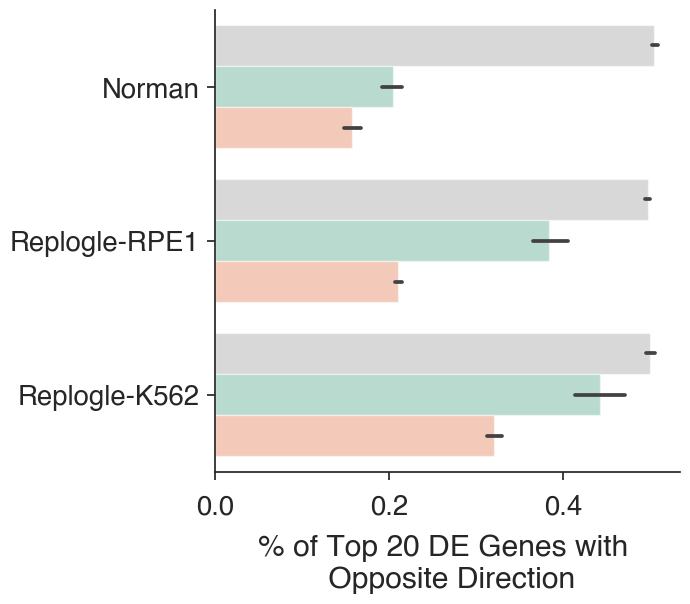

In [10]:
sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Helvetica", font_scale=1.8)

g = sns.barplot('% of Top 20 DE Genes with Opposite Direction', 'dataset', hue = 'method',
    data=df,  hue_order = [ 'No-Perturb', 'CPA', 'GEARS'],
    palette=[pal[0],'#66c2a5', '#fc8d62'], saturation=0.75, orient = 'h', alpha = 0.5)
sns.despine()
g.legend_.remove()
g.set(ylabel=None)

plt.xlabel("% of Top 20 DE Genes with \n Opposite Direction",labelpad=10)
plt.tick_params(axis='x', which='major', pad=10)
plt.tick_params(axis='y', which='major', pad=5)
#g.spines['left'].set_linewidth(0.8)
#g.spines['bottom'].set_linewidth(0.8)

plt.savefig('direction_top20_bar.pdf', bbox_inches='tight')

/dfs/user/kexinh/miniconda3/envs/a100_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


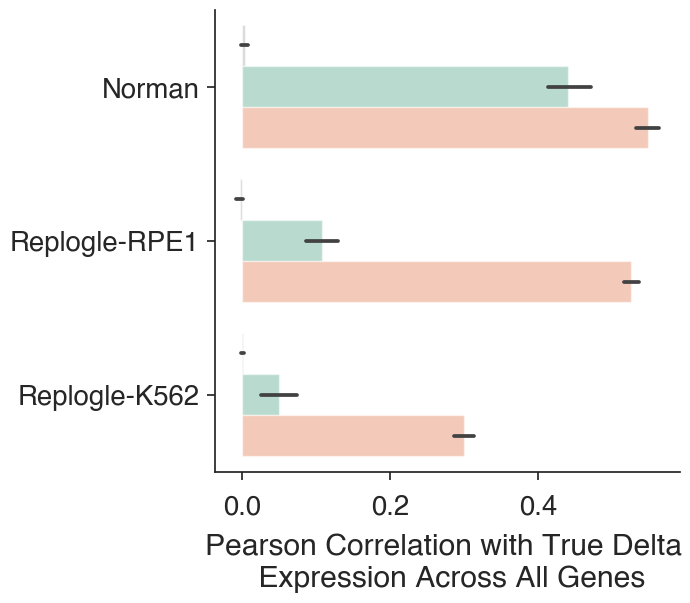

In [11]:
sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Helvetica", font_scale=1.8)

g = sns.barplot('Pearson Correlation Across All Genes', 'dataset', hue = 'method',
    data=df,  hue_order = [ 'No-Perturb', 'CPA', 'GEARS'],
    palette=[pal[0],'#66c2a5', '#fc8d62'], saturation=0.75, orient = 'h', alpha = 0.5)
sns.despine()
g.legend_.remove()
g.set(ylabel=None)

plt.xlabel("Pearson Correlation with True Delta \n Expression Across All Genes",labelpad=10)
plt.tick_params(axis='x', which='major', pad=10)
plt.tick_params(axis='y', which='major', pad=5)
#g.spines['left'].set_linewidth(0.8)
#g.spines['bottom'].set_linewidth(0.8)

#plt.savefig('pearson_bar.pdf', bbox_inches='tight')

/dfs/user/kexinh/miniconda3/envs/a100_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


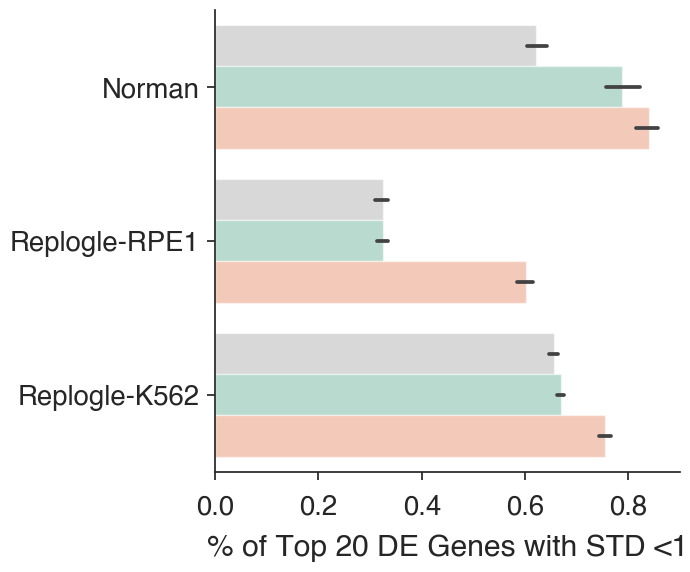

In [12]:
g = sns.barplot('% of STD <1', 'dataset', hue = 'method',
     data=df,  hue_order = [ 'No-Perturb', 'CPA', 'GEARS'],
    palette=[pal[0],'#66c2a5', '#fc8d62'], saturation=0.75, orient = 'h', alpha = 0.5)
sns.despine()
g.legend_.remove()
g.set(ylabel=None)

plt.xlabel("% of Top 20 DE Genes with STD <1",labelpad=10)
plt.tick_params(axis='x', which='major', pad=10)
plt.tick_params(axis='y', which='major', pad=5)
#g.spines['left'].set_linewidth(0.8)
#g.spines['bottom'].set_linewidth(0.8)

plt.savefig('std_bar.pdf', bbox_inches='tight')